Authenticating with kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Downloading kaggle's Sign Language MNIST dataset

In [ ]:
! kaggle datasets download -d datamunge/sign-language-mnist


100% 62.6M/62.6M [00:04<00:00, 20.8MB/s]
100% 62.6M/62.6M [00:04<00:00, 16.0MB/s]


Extracting the contents of zip file

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/sign-language-mnist.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
## Importing important libraries

In [ ]:
import pandas as pd
import numpy as np
import csv
from PIL import Image
import os
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

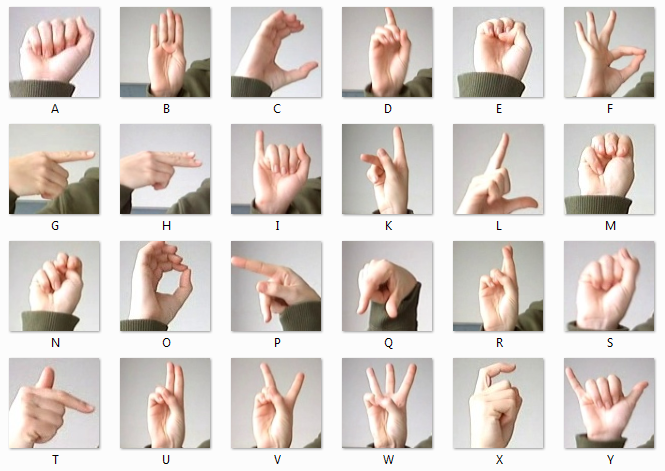

In [ ]:
img_sign =cv.imread('/content/amer_sign2.png')
cv2_imshow(img_sign)   ## Here is the image on which we are going to perform pre-processing techniques.

In [ ]:
data = pd.read_csv('/content/sign_mnist_train.csv')   ## reading csv file -> sign_mnist_train.csv

In [ ]:
data.head(10)      ## taking a glimpse of idea how are data looks

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
5,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255
6,8,134,134,135,135,136,137,137,138,138,...,109,102,91,65,138,189,179,181,181,179
7,22,114,42,74,99,104,109,117,127,142,...,214,218,220,223,223,225,227,227,228,228
8,3,169,174,176,180,183,185,187,188,190,...,119,118,123,120,118,114,94,74,61,57
9,3,189,189,189,190,190,191,190,190,190,...,13,53,200,204,201,201,193,175,178,156


In [ ]:

def create_input_directory(csv_file, input_dir):
    # Create the input directory if it doesn't exist
    os.makedirs(input_dir, exist_ok=True)

    # Read the CSV file and process each row
    with open(csv_file, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)  # Skip the header row if it exists
        images = []
        labels = []
        for idx, row in enumerate(csvreader):
            # Extract the label and pixel data from the CSV row
            label = int(row[0])  # Assuming the label is in the first column
            pixel_data = np.array(row[1:], dtype=np.uint8)

            # Reshape the pixel data into a 28x28 image
            image = pixel_data.reshape(28, 28)
            labels.append(label)
            images.append(image)

            # Save the image as a PNG file in the output directory
            image_filename = os.path.join(input_dir, f'image_{idx:04d}.png')
            image = Image.fromarray(image)
            image.save(image_filename)

    # Convert the list of images to a NumPy array
    images = np.array(images)
    labels = np.array(labels)

    print(f"Input directory created at: {input_dir}")
    return images,labels


csv_file_path = '/content/sign_mnist_train.csv'
input_directory = '/content/input_directory'
images,labels = create_input_directory(csv_file_path, input_directory)



Input directory created at: /content/input_directory


In [ ]:
print('Shape of training Images:',images.shape)
print('Length of unique Training Labels:',len(set(labels)))

Shape of training Images: (27455, 28, 28)
Length of unique Training Labels: 24


In [ ]:
images_gray = np.expand_dims(images, axis=3)  ## Expanding the dimensions of the training set as color channel for grayscale is 1

In [ ]:
print('Shape of training Images:',images_gray.shape)

Shape of training Images: (27455, 28, 28, 1)


encoding labels to its corresponding alphabet

In [ ]:
def encode_label_to_alphabet(label):
        return chr(ord('A') + label)


encoded_labels = [encode_label_to_alphabet(label) for label in labels]

In [ ]:
images_gray = images_gray/255.0    # Normalize pixel values


Splitting the data into train and validtion set


In [ ]:
X_train, X_valid,y_train, y_valid = train_test_split(images_gray,labels ,
                                   random_state=104,
                                   test_size=0.2,
                                   shuffle=True)

In [ ]:
X_valid[0].shape

(28, 28, 1)

Creating an output directory for Grayscale Image and encoded labels

In [ ]:

def create_directories(images_gray, labels, encoded_labels, output_dir):
    # Create the main output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Create subdirectories for each data type (images, labels, encoded_labels)
    image_dir = os.path.join(output_dir, 'images')
    label_dir = os.path.join(output_dir, 'labels')
    encoded_label_dir = os.path.join(output_dir, 'encoded_labels')

    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)
    os.makedirs(encoded_label_dir, exist_ok=True)

    # Save images_gray, labels, and encoded_labels to their respective directories
    for i in range(len(images_gray)):
        # Save the image
        image_filename = os.path.join(image_dir, f'image_{i:04d}.png')
        image_array = images_gray[i].squeeze()  # Remove single-channel dimension if present
        image = Image.fromarray(image_array.astype(np.uint8))
        image.save(image_filename)

        # Save the label (as text)
        label_filename = os.path.join(label_dir, f'label_{i:04d}.txt')
        with open(label_filename, 'w') as label_file:
            label_file.write(str(labels[i]))

        # Save the encoded_label (as text)
        encoded_label_filename = os.path.join(encoded_label_dir, f'encoded_label_{i:04d}.txt')
        with open(encoded_label_filename, 'w') as encoded_label_file:
            encoded_label_file.write(encoded_labels[i])

# Example usage:
# Assume you have images_gray, labels, and encoded_labels as NumPy arrays.
# Replace 'output_directory' with your desired output directory path.
output_directory = 'output_directory'
create_directories(images_gray, labels, encoded_labels, output_directory)


Giving user the option to augment the data

In [ ]:
def ask_for_augmentation():
    while True:
        try:
            user_input = input("Do you want to perform data augmentation? (True/False): ").strip().lower()
            if user_input in ["true", "false","True","False","TRUE","FALSE"]:
                return user_input in ["true","True","TRUE"]
            else:
                print("Invalid input. Please enter 'True' or 'False'.")
        except KeyboardInterrupt:
            print("\nUser interrupted. Exiting.")
            exit()

perform_augmentation = ask_for_augmentation()
if perform_augmentation:
    # Perform data augmentation
    print("Data augmentation is enabled.")
    datagen =ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    datagen.fit(X_train)
    datagen.fit(X_valid)
else:
    # Do not perform data augmentation
    print("Data augmentation is disabled.")


Do you want to perform data augmentation? (True/False): False
Data augmentation is disabled.


In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_train[0].shape
from keras.models import Sequential
from keras.layers import Conv2D, Dense, BatchNormalization, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Build simple model
import keras
model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)),
                    MaxPool2D(2,2, padding='same'),
                    Dropout(0.2),

                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    Dropout(0.2),

                    Conv2D(filters=512, kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    Dropout(0.2),


                    Flatten(),

                    Dense(units=4096, activation="relu"),
                    Dropout(0.2),

                    Dense(units=1024, activation="relu"),
                    Dropout(0.2),
                     Dense(units=256, activation="relu"),
                    Dropout(0.2),

                    Dense(units=25, activation="softmax"),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

In [ ]:
# compile the model
import tensorflow as tf
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [ ]:
checkpoint_filepath = 'best_model.hdf5'

callback_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callbacks = [callback_checkpoint]

In [ ]:
# fit the model
history = model.fit(X_train,X_valid,epochs=20, callbacks=callbacks)

Epoch 1/20
172/172 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0406

172/172 [==============================] - 13s 54ms/step - loss: nan - accuracy: 0.0406 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 2/20
171/172 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0407

172/172 [==============================] - 7s 43ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 3/20
172/172 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0407

172/172 [==============================] - 8s 48ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 4/20
172/172 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0407

172/172 [==============================] - 7s 42ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 5/20
171/172 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0407

172/172 [==============================] - 7s 43ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 6/20
171/172 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0408

172/172 [==============================] - 9s 50ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 7/20
171/172 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0408

172/172 [==============================] - 8s 48ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 8/20
172/172 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0407

172/172 [==============================] - 7s 42ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 9/20
171/172 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0406

172/172 [==============================] - 8s 47ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 10/20
172/172 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0407

172/172 [==============================] - 8s 48ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 11/20
171/172 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0407

172/172 [==============================] - 8s 47ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 12/20
171/172 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0408

172/172 [==============================] - 7s 41ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 13/20
172/172 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0407

172/172 [==============================] - 7s 42ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 14/20
172/172 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0407

172/172 [==============================] - 8s 48ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 15/20
171/172 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0406

172/172 [==============================] - 7s 42ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 16/20
172/172 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0407

172/172 [==============================] - 8s 47ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 17/20
171/172 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0407

172/172 [==============================] - 8s 48ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 18/20
171/172 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0405

172/172 [==============================] - 7s 42ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 19/20
172/172 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0407

172/172 [==============================] - 8s 49ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010
Epoch 20/20
172/172 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0407

172/172 [==============================] - 7s 42ms/step - loss: nan - accuracy: 0.0407 - val_loss: nan - val_accuracy: 0.0423 - lr: 0.0010


In [ ]:
df1 = pd.read_csv('/content/sign_mnist_test.csv')
images1 = df1.drop(columns='label')
labels1 = df1['label'].values
new_shape = (7172, 28, 28)
images1 = images1.values.reshape(new_shape)

In [ ]:
df1.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [ ]:
X_test = images1
y_test = labels1

In [ ]:
y_test[0]

6

In [ ]:
y_pred = model.predict(X_test).round(2)

225/225 [==============================] - 1s 2ms/step


In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

225/225 - 1s - loss: 53.0155 - accuracy: 0.8519 - 1s/epoch - 5ms/step


In [ ]:
test_acc

0.8519241213798523

In [ ]:
model.predict(np.expand_dims(X_test[0], axis = 0)).round(2)

1/1 [==============================] - 0s 123ms/step


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
model.save("final_model_cnn(1).h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import cv2

In [ ]:
gray_scale_image = cv.imread('/content/L.jpeg', cv.IMREAD_GRAYSCALE)
print("gray shape:", gray_scale_image.shape)
resized_gray_image = cv.resize(gray_scale_image, (28, 28))
flat_img = resized_gray_image.flatten()
flat_img = flat_img.reshape(28, 28, 1)  # Remove the extra dimension
input_data = np.expand_dims(flat_img, axis=0)  # Add batch dimension

gray shape: (225, 225)


In [ ]:
model.predict(input_data).round(2)

1/1 [==============================] - 0s 32ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
model.predict(np.expand_dims(X_test[0], axis = 0)).round(2)